In [1]:

import pandas as pd
import numpy as np
from jeffutils.utils import set_np_pd_display_params, print_display, movecol
import os
import matplotlib.pyplot as plt
from itertools import product
from sklearn.neighbors import KernelDensity
from collections import defaultdict
from tqdm.auto import tqdm
from random import choice
import random
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
import pickle
from scipy.stats import entropy, wasserstein_distance, pearsonr
import json
from copy import deepcopy

from py_files.data_manager import RELEVANT_COLUMNS, EVENTS_IGNORED, load_and_clean_csv
from py_files.helper_funcs import get_data, get_label_encoder

set_np_pd_display_params(np, pd)
# set max rows for pandas dataframe to 100
pd.set_option("display.max_rows", 100)

DATA_PATH = "data/play_by_play/"

# comparing accuracies

In [2]:
df_full = pd.read_feather("data/play_by_play/play_by_play_full_state_space.feather")

In [3]:
game_ids = [2022020839, 2023020412, 2022020727, 2022030154, 
    2022021296, 2023020164, 2022020793, 2023020317, 
    2022020971, 2022030145, 2022020938, 2022021300, 
    2022021101, 2022020747, 2023020254, 2022020832, 
    2022020842, 2022021012, 2023020268, 2022020867, 
    2022030324, 2023020546, 2022021001, 2022021055, 
    2023020464, 2022021181, 2023020096, 2022020688, 
    2023020325, 2022021166, 2022020932, 2022020843, 
    2023020365, 2022030245, 2022021040, 2022021088, 
    2023020570, 2023020264, 2023020129, 2022020876, 
    2023020292, 2023020010, 2022021270, 2022021115, 
    2022020753, 2023020475, 2023020192, 2022020662, 
    2023020033, 2023020482]

dfs = []
for game_id in game_ids:
    path = f"data/pickles/simulation_probs_{game_id}.pickle"
    with open(path, "rb") as f:
        data = pickle.load(f)
    game_id = data['game_id']
    curr_game = data['curr_game'].reset_index(drop=True)
    rows_to_simulate = data['rows_to_simulate']
    simulation_probabilities = data['simulation_probabilities']
    home_probs = [x[0] for x in simulation_probabilities]
    
    df = curr_game.loc[rows_to_simulate, ['game_id', 'game_seconds']].copy()
    df['probability_home'] = home_probs
    dfs.append(df)
    
mcmc_df = pd.concat(dfs, ignore_index=True).reset_index(drop=True)
mcmc_df = mcmc_df.sort_values(by=['game_id', 'game_seconds']).reset_index(drop=True)

In [4]:
# load in the bayesian and xgboost probabilities
bayesian_df = pd.read_feather("data/predictions/bayesian_outcomes.feather")
bayesian_df = bayesian_df.rename(columns={
    "time_remaining": "game_seconds",
    "home_team_win_probability": "probability_home"})
bayesian_df['game_seconds'] = 3600 - bayesian_df['game_seconds']
bayesian_df = bayesian_df.sort_values(by=['game_id', 'game_seconds']).reset_index(drop=True)

xgboost_df = pd.read_feather("data/predictions/xgboost_results_df (1).feather")
xgboost_df = xgboost_df.sort_values(by=['game_id', 'game_seconds']).reset_index(drop=True)

# find the game_ids that all of the dataframes have in common
bayesian_game_ids = bayesian_df['game_id'].unique()
xgboost_game_ids = xgboost_df['game_id'].unique()

selected_game_ids = mcmc_df['game_id'].unique()
selected_game_ids = [x for x in selected_game_ids if x in bayesian_game_ids and x in xgboost_game_ids]

# filter the game_ids list to have an even representation of home and away wins
winners = df_full.loc[
    df_full['game_id'].isin(selected_game_ids), 
    ['game_id', 'home_final', 'away_final']].copy()
winners['winner'] = np.where(winners['home_final'] >= winners['away_final'], 1, 0)
winners = winners.drop(columns=['home_final', 'away_final'])
winners = winners.drop_duplicates().sample(frac=1.0).reset_index(drop=True)

per_group = winners['winner'].value_counts()[0]
homes = winners.loc[winners['winner'] == 1].sample(per_group)['game_id'].values
aways = winners.loc[winners['winner'] == 0]['game_id'].values

game_ids_even = np.concatenate([homes, aways])
selected_game_ids = deepcopy(game_ids_even)

# filter the mcmc, bayesian, and xgboost dataframes to only have the selected game_ids
mcmc_df = mcmc_df.loc[mcmc_df['game_id'].isin(game_ids_even)].copy()
bayesian_df = bayesian_df.loc[bayesian_df['game_id'].isin(game_ids_even)].copy()
xgboost_df = xgboost_df.loc[xgboost_df['game_id'].isin(game_ids_even)].copy()


In [5]:
mcmc_df['id_seconds'] = mcmc_df['game_id'].astype(str) + "0" + mcmc_df['game_seconds'].astype(str).str.zfill(5)
mcmc_df['id_seconds'] = mcmc_df['id_seconds'].astype(int)

bayesian_df['id_seconds'] = bayesian_df['game_id'].astype(str) + "0" + bayesian_df['game_seconds'].astype(str).str.zfill(5)
bayesian_df['id_seconds'] = bayesian_df['id_seconds'].astype(int)

xgboost_df['id_seconds'] = xgboost_df['game_id'].astype(str) + "0" + xgboost_df['game_seconds'].astype(str).str.zfill(5)
xgboost_df['id_seconds'] = xgboost_df['id_seconds'].astype(int)

mcmc_df = mcmc_df.sort_values(by=['id_seconds']).reset_index(drop=True)
bayesian_df = bayesian_df.sort_values(by=['id_seconds']).reset_index(drop=True)
xgboost_df = xgboost_df.sort_values(by=['id_seconds']).reset_index(drop=True)

df = pd.merge_asof(
    mcmc_df,
    xgboost_df,
    on="id_seconds",
    direction="nearest",
    suffixes=('_mcmc', '_xgboost'))
df = pd.merge_asof(
    df,
    bayesian_df,
    on="id_seconds",
    direction="nearest")
df = df.rename(columns={
    'game_id': 'game_id_bayesian',
    'game_seconds': 'game_seconds_bayesian',
    'probability_home': 'probability_home_bayesian'})
df = df.drop(columns=[
    'id_seconds', 'game_id_xgboost','game_seconds_xgboost',
    'game_id_bayesian',	'game_seconds_bayesian'
]).rename(columns={'game_id_mcmc':'game_id', 'game_seconds_mcmc':'game_seconds'})
display(df)


,game_id,game_seconds,probability_home_mcmc,probability_home_xgboost,probability_home_bayesian
0,2022020662,0,0.4600000,0.0519325,0.5296259
1,2022020662,332,0.3800000,0.0705096,0.3071682
2,2022020662,704,0.2400000,0.0095729,0.1509664
3,2022020662,990,0.3600000,0.0046964,0.2490088
4,2022020662,1272,0.3800000,0.0038169,0.2490088
...,...,...,...,...,...
389,2023020570,2004,0.2400000,0.0324258,0.3071682
390,2023020570,2400,0.5200000,0.0415833,0.5270507
391,2023020570,2919,0.8400000,0.0935756,0.7570922
392,2023020570,3257,0.8800000,0.0616562,0.7570922


In [6]:
predictions = df.copy()
winners = df_full.loc[
    df_full['game_id'].isin(selected_game_ids), 
    ['game_id', 'home_final', 'away_final']].copy()
winners['winner'] = np.where(winners['home_final'] >= winners['away_final'], 1, 0)
winners = winners.drop(columns=['home_final', 'away_final'])

predictions['mcmc'] = (predictions['probability_home_mcmc'] >= 0.5).astype(int)
predictions['xgboost'] = (predictions['probability_home_xgboost'] >= 0.5).astype(int)
predictions['bayesian'] = (predictions['probability_home_bayesian'] >= 0.5).astype(int)

predictions = pd.merge(predictions, winners, on='game_id').drop_duplicates().reset_index(drop=True)
display(predictions)

,game_id,game_seconds,probability_home_mcmc,probability_home_xgboost,probability_home_bayesian,mcmc,xgboost,bayesian,winner
0,2022020662,0,0.4600000,0.0519325,0.5296259,0,0,1,0
1,2022020662,332,0.3800000,0.0705096,0.3071682,0,0,0,0
2,2022020662,704,0.2400000,0.0095729,0.1509664,0,0,0,0
3,2022020662,990,0.3600000,0.0046964,0.2490088,0,0,0,0
4,2022020662,1272,0.3800000,0.0038169,0.2490088,0,0,0,0
...,...,...,...,...,...,...,...,...,...
389,2023020570,2004,0.2400000,0.0324258,0.3071682,0,0,0,1
390,2023020570,2400,0.5200000,0.0415833,0.5270507,1,0,1,1
391,2023020570,2919,0.8400000,0.0935756,0.7570922,1,0,1,1
392,2023020570,3257,0.8800000,0.0616562,0.7570922,1,0,1,1


In [7]:
quarter_starts = np.array([0, 1200, 2400, 3600])
times = np.array([0, 600, 1200, 1800, 2400, 3000, 3540])

table_data = list(product(selected_game_ids, times))
table = pd.DataFrame(table_data, columns=['game_id', 'game_seconds'])

table['id_sec'] = (table['game_id'].astype(str) + "0" + 
    table['game_seconds'].astype(str).str.zfill(5))
table['id_sec'] = table['id_sec'].astype(int)
predictions['id_sec'] = (predictions['game_id'].astype(str) + "0" + 
    predictions['game_seconds'].astype(str).str.zfill(5))
predictions['id_sec'] = predictions['id_sec'].astype(int)

table = pd.merge_asof(
    table.sort_values(by='id_sec'),
    predictions.sort_values(by='id_sec'),
    on="id_sec",
    direction="nearest",
    suffixes=('_table', '_pred'))
table = (table
    .drop(columns=['id_sec', 'game_id_pred'])
    .rename(columns={'game_id_table':'game_id'})
)
display(table)



,game_id,game_seconds_table,game_seconds_pred,probability_home_mcmc,probability_home_xgboost,probability_home_bayesian,mcmc,xgboost,bayesian,winner
0,2022020662,0,0,0.4600000,0.0519325,0.5296259,0,0,1,0
1,2022020662,600,704,0.2400000,0.0095729,0.1509664,0,0,0,0
2,2022020662,1200,1272,0.3800000,0.0038169,0.2490088,0,0,0,0
3,2022020662,1800,1672,0.3000000,0.0039752,0.2490088,0,0,0,0
4,2022020662,2400,2416,0.0800000,0.0037812,0.0977282,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
247,2023020570,1200,1286,0.4600000,0.0190011,0.3071682,0,0,0,1
248,2023020570,1800,2004,0.2400000,0.0324258,0.3071682,0,0,0,1
249,2023020570,2400,2400,0.5200000,0.0415833,0.5270507,1,0,1,1
250,2023020570,3000,2919,0.8400000,0.0935756,0.7570922,1,0,1,1


In [10]:
avg_probs = (table
    .groupby(by=['game_seconds_table', 'winner'])
    [['probability_home_mcmc',	'probability_home_xgboost',	'probability_home_bayesian']]
    .mean()
    .reset_index()
    .rename(columns={
        'probability_home_mcmc': 'mcmc_avg_home_prob',
        'probability_home_xgboost': 'xgboost_avg_home_prob',
        'probability_home_bayesian': 'bayesian_avg_home_prob',
        'winner': 'home_won'
    })
    .sort_values(by=['home_won', 'game_seconds_table']))
avg_probs = movecol(avg_probs, ['home_won'], 'game_seconds_table', 'Before')
avg_probs = avg_probs.rename(columns={'game_seconds_table': 'game_seconds'})
display(avg_probs)

,home_won,game_seconds,mcmc_avg_home_prob,xgboost_avg_home_prob,bayesian_avg_home_prob
0,0,0,0.5444444,0.4320166,0.5296259
2,0,600,0.4788889,0.1275180,0.4551299
4,0,1200,0.4277778,0.0876134,0.3892424
6,0,1800,0.3533333,0.0738943,0.3184306
8,0,2400,0.2122222,0.0588901,0.2090609
10,0,3000,0.1833333,0.0694896,0.1926672
12,0,3540,0.0600000,0.0551617,0.1425582
1,1,0,0.5511111,0.5211381,0.5296259
3,1,600,0.5822222,0.2367166,0.5748986
5,1,1200,0.6411111,0.1873585,0.6359483


In [11]:
print(dict([('a',1), ('b',2), ('c',3)]))

{'a': 1, 'b': 2, 'c': 3}


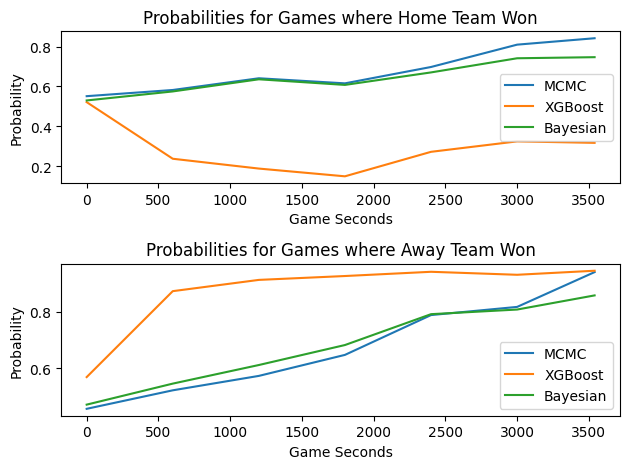

In [15]:
probs_home = avg_probs.loc[avg_probs['home_won'] == 1].copy()
probs_away = avg_probs.loc[avg_probs['home_won'] == 0].copy()

plt.subplot(2,1,1)
plt.title("Probabilities for Games where Home Team Won")
plt.plot(probs_home['game_seconds'], probs_home['mcmc_avg_home_prob'], label='MCMC')
plt.plot(probs_home['game_seconds'], probs_home['xgboost_avg_home_prob'], label='XGBoost')
plt.plot(probs_home['game_seconds'], probs_home['bayesian_avg_home_prob'], label='Bayesian')
plt.xlabel("Game Seconds")
plt.ylabel("Probability")
plt.legend()

probs_away['mcmc_avg_home_prob'] = 1 - probs_away['mcmc_avg_home_prob']
probs_away['xgboost_avg_home_prob'] = 1 - probs_away['xgboost_avg_home_prob']
probs_away['bayesian_avg_home_prob'] = 1 - probs_away['bayesian_avg_home_prob']
probs_away_col_renames = [
    ('mcmc_avg_home_prob', 'mcmc_avg_away_prob'),
    ('xgboost_avg_home_prob', 'xgboost_avg_away_prob'),
    ('bayesian_avg_home_prob', 'bayesian_avg_away_prob')
]
probs_away = probs_away.rename(columns=dict(probs_away_col_renames))

plt.subplot(2,1,2)
plt.title("Probabilities for Games where Away Team Won")
plt.plot(probs_away['game_seconds'], probs_away['mcmc_avg_away_prob'], label='MCMC')
plt.plot(probs_away['game_seconds'], probs_away['xgboost_avg_away_prob'], label='XGBoost')
plt.plot(probs_away['game_seconds'], probs_away['bayesian_avg_away_prob'], label='Bayesian')
plt.xlabel("Game Seconds")
plt.ylabel("Probability")
plt.legend()

plt.tight_layout()
plt.show()



In [9]:
table['mcmc_correct'] = (table['mcmc'] == table['winner']).astype(int)
table['xgboost_correct'] = (table['xgboost'] == table['winner']).astype(int)
table['bayesian_correct'] = (table['bayesian'] == table['winner']).astype(int)
accuracies = (table
    .groupby(by='game_seconds_table')
    [['mcmc_correct', 'xgboost_correct', 'bayesian_correct']]
    .sum()
    .reset_index()
)
accuracies['games'] = 49
accuracies['mcmc_accuracy'] = accuracies['mcmc_correct'] / accuracies['games']
accuracies['xgboost_accuracy'] = accuracies['xgboost_correct'] / accuracies['games']
accuracies['bayesian_accuracy'] = accuracies['bayesian_correct'] / accuracies['games']
accuracies = (accuracies
    .drop(columns=['mcmc_correct', 'xgboost_correct', 'bayesian_correct', 'games'])
    .rename(columns={'game_seconds_table': 'game_seconds'}))
display(accuracies)

,game_seconds,mcmc_accuracy,xgboost_accuracy,bayesian_accuracy
0,0,0.4285714,0.4285714,0.3673469
1,600,0.4285714,0.4285714,0.4081633
2,1200,0.4489796,0.4081633,0.4693878
3,1800,0.5102041,0.3877551,0.4897959
4,2400,0.6122449,0.4693878,0.5918367
5,3000,0.6122449,0.4693878,0.6530612
6,3540,0.6734694,0.4693878,0.6326531
